In [1]:
import sys
sys.path.append('/Users/hamzacostelle/opt/anaconda3/envs/project-env/lib/python3.7/site-packages')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1963k  100 1963k    0     0   852k      0  0:00:02  0:00:02 --:--:--  855k


In [4]:
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')

In [5]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


Attribute Information:

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (â„ƒ)
- TEMP: Temperature (â„ƒ)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

- The concentration of an air pollutant (eg. ozone) is given in micrograms (one-millionth of a gram) per cubic meter air or µg/m3.


- 5 is considered safe by the US Environmental Protection Agency's national ambient air quality standards so long as a person breathes in an average of 12 micrograms per cubic meter of air (μg/m3) or less per day over the duration of a year.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [7]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [8]:
#Dropping the first day as the pm2.5 column only has 'nan' values 
df = df[24:].fillna(method='ffill')
df['pm2.5'].isna().sum()

0

In [9]:
df2 = df.copy()
df2['Time'] = df2.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df2.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
df2 = df2.set_index('Time')
df2.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [10]:
#Creating dummy variables for the cbwd: Combined wind direction
df2 = df2.join(pd.get_dummies(df2['cbwd'])) # one-hot encoding
del df2['cbwd']
df2.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
Time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


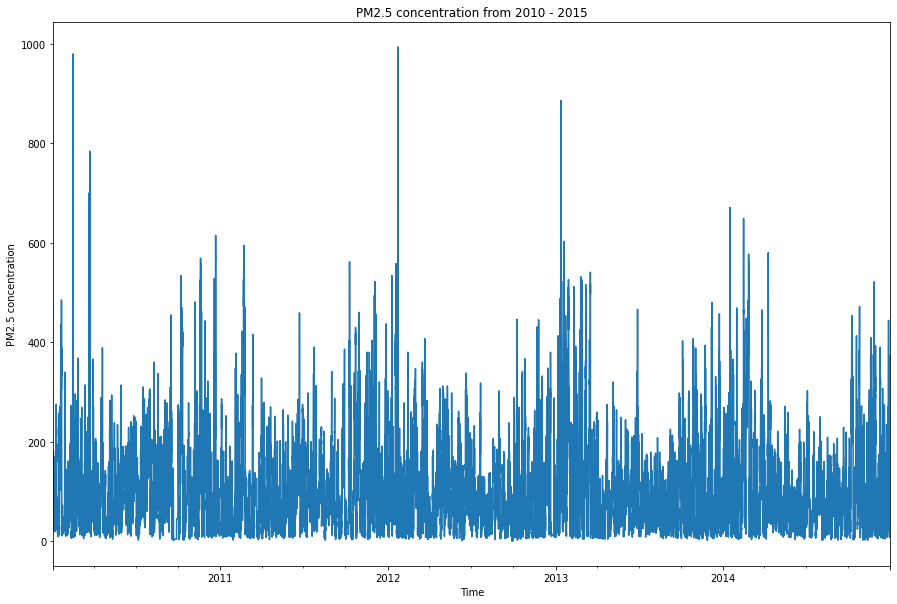

In [11]:
plt.subplots(figsize=(15,10))
plt.xlabel('Time')
plt.ylabel('PM2.5 concentration')
plt.title('PM2.5 concentration from 2010 - 2015')
df2['pm2.5'].plot()
plt.show()

In [13]:
scatter_y = df2['pm2.5'].resample('D').mean()
scatter_x = df2['pm2.5'].resample('D').mean().index

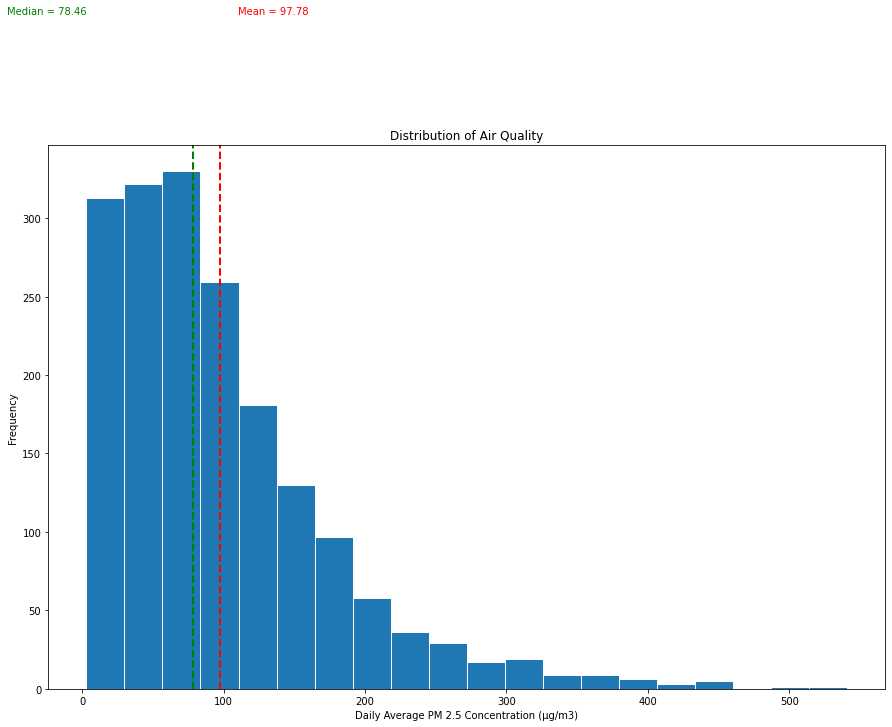

In [24]:
plt.figure(figsize=(15,10))
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)
plt.show()

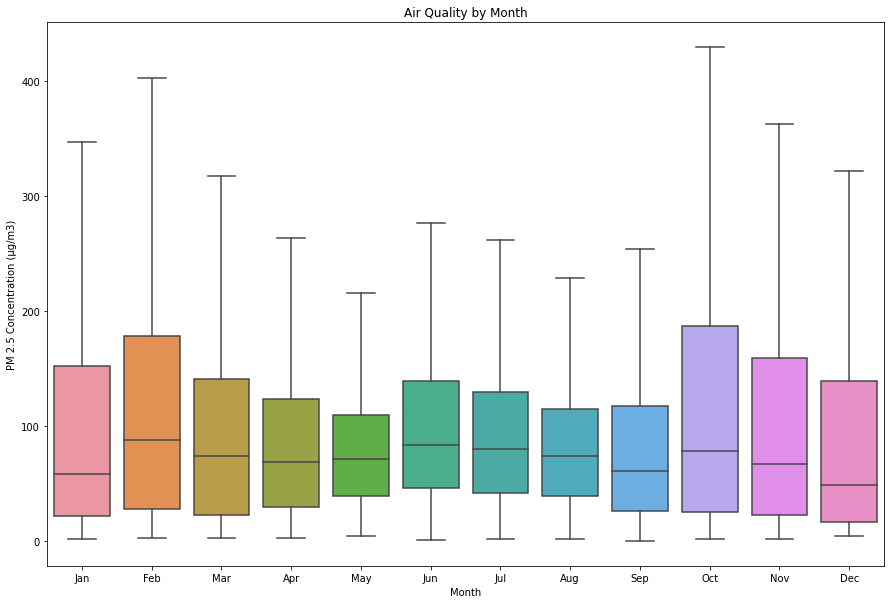

In [21]:
import calendar
plt.figure(figsize=(15,10))
sns.boxplot(x="month", y="pm2.5", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])
plt.show()

In [28]:
values=df2.values

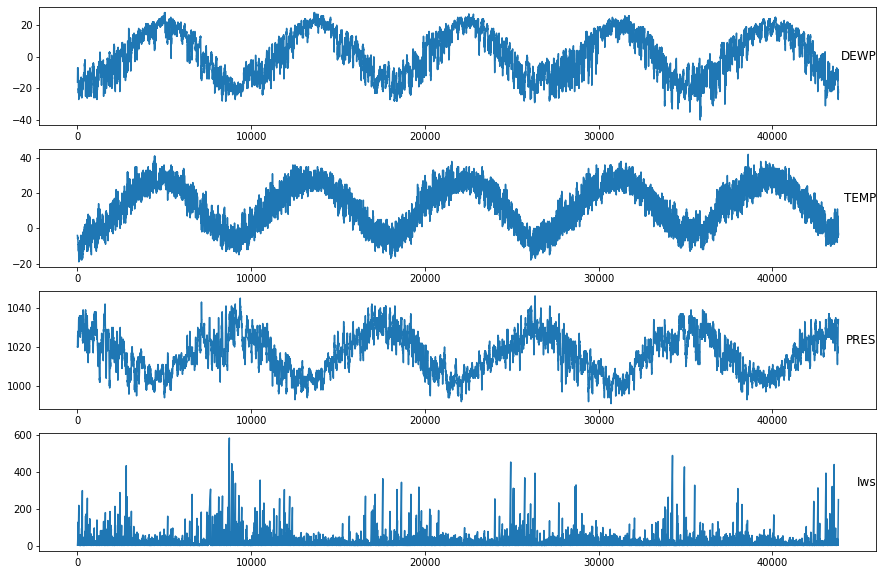

In [29]:
# specify columns to plot
groups = [1,2,3,4]
i = 1
# plotting each column
plt.figure(figsize=(15,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df2.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [15]:
df_numeric = df2.loc[:,['Iws','DEWP','TEMP','PRES', 'Is','Ir']]
df_numeric

,Iws,DEWP,TEMP,PRES,Is,Ir
Time,,,,,,
2010-01-02 00:00:00,1.79,-16,-4.0,1020.0,0,0
2010-01-02 01:00:00,2.68,-15,-4.0,1020.0,0,0
2010-01-02 02:00:00,3.57,-11,-5.0,1021.0,0,0
2010-01-02 03:00:00,5.36,-7,-5.0,1022.0,1,0
2010-01-02 04:00:00,6.25,-7,-5.0,1022.0,2,0
...,...,...,...,...,...,...
2014-12-31 19:00:00,231.97,-23,-2.0,1034.0,0,0
2014-12-31 20:00:00,237.78,-22,-3.0,1034.0,0,0
2014-12-31 21:00:00,242.70,-22,-3.0,1034.0,0,0


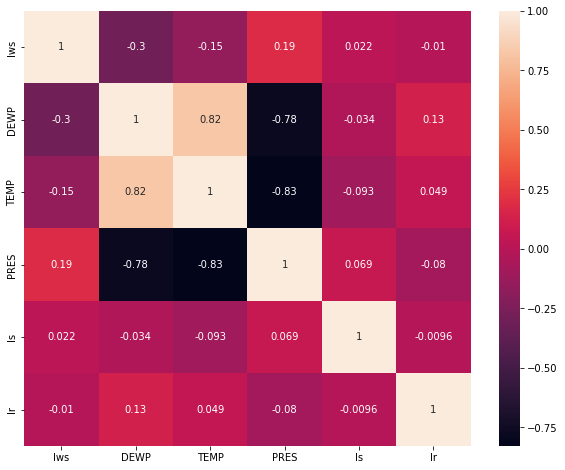

In [16]:
corr = df_numeric.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True)
plt.show()

In [17]:
scaler = StandardScaler()
df3 = scaler.fit_transform(df_numeric)

In [18]:
df4 = pd.DataFrame(data=df3, index=df_numeric.index, columns=df_numeric.columns)
df4

,Iws,DEWP,TEMP,PRES,Is,Ir
Time,,,,,,
2010-01-02 00:00:00,-0.441890,-1.235589,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 01:00:00,-0.424098,-1.166285,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 02:00:00,-0.406306,-0.889069,-1.431862,0.443244,-0.069372,-0.137706
2010-01-02 03:00:00,-0.370522,-0.611852,-1.431862,0.540603,1.245425,-0.137706
2010-01-02 04:00:00,-0.352730,-0.611852,-1.431862,0.540603,2.560223,-0.137706
...,...,...,...,...,...,...
2014-12-31 19:00:00,4.159670,-1.720718,-1.185824,1.708908,-0.069372,-0.137706
2014-12-31 20:00:00,4.275819,-1.651414,-1.267837,1.708908,-0.069372,-0.137706
2014-12-31 21:00:00,4.374175,-1.651414,-1.267837,1.708908,-0.069372,-0.137706


In [19]:
df5 = df2.drop(['Iws','DEWP','TEMP','PRES', 'Is','Ir'], axis = 1)
final_df = pd.concat([df5,df4], axis = 1)
final_df

,pm2.5,NE,NW,SE,cv,Iws,DEWP,TEMP,PRES,Is,Ir
Time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,0,0,1,0,-0.441890,-1.235589,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 01:00:00,148.0,0,0,1,0,-0.424098,-1.166285,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 02:00:00,159.0,0,0,1,0,-0.406306,-0.889069,-1.431862,0.443244,-0.069372,-0.137706
2010-01-02 03:00:00,181.0,0,0,1,0,-0.370522,-0.611852,-1.431862,0.540603,1.245425,-0.137706
2010-01-02 04:00:00,138.0,0,0,1,0,-0.352730,-0.611852,-1.431862,0.540603,2.560223,-0.137706
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,0,1,0,0,4.159670,-1.720718,-1.185824,1.708908,-0.069372,-0.137706
2014-12-31 20:00:00,10.0,0,1,0,0,4.275819,-1.651414,-1.267837,1.708908,-0.069372,-0.137706
2014-12-31 21:00:00,10.0,0,1,0,0,4.374175,-1.651414,-1.267837,1.708908,-0.069372,-0.137706


In [20]:
#Train-test Split 
features = final_df.drop("pm2.5",axis=1)
X = features
y = final_df['pm2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 0)

In [21]:
l_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
rnd_reg = RandomForestRegressor(n_estimators=30, random_state=0)
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
lasso_reg = Lasso(alpha=0.1)
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
ridge_reg = Ridge(alpha=.5, solver="cholesky", random_state=0)
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(random_state=0), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=0)

In [22]:
for reg in (l_reg,tree_reg,rnd_reg,sgd_reg,lasso_reg,elastic_reg,ridge_reg, bag_reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(reg.__class__.__name__," r2_score: ",  r2_score(y_test, y_pred))
    print(reg.__class__.__name__,' MSE: ',  mean_squared_error(y_test, y_pred))
    print(reg.__class__.__name__," RMSE: " , np.sqrt(mean_squared_error(y_test, y_pred)))
    print('\n')

LinearRegression  r2_score:  0.24595235004707117
LinearRegression  MSE:  6464.9818929881
LinearRegression  RMSE:  80.40511111234223


DecisionTreeRegressor  r2_score:  -0.09227191798145262
DecisionTreeRegressor  MSE:  9364.81689507326
DecisionTreeRegressor  RMSE:  96.7719840401821


RandomForestRegressor  r2_score:  0.40141041151332113
RandomForestRegressor  MSE:  5132.130378152034
RandomForestRegressor  RMSE:  71.63888872778551


SGDRegressor  r2_score:  0.24570940502028826
SGDRegressor  MSE:  6467.064831910117
SGDRegressor  RMSE:  80.41806284604297


Lasso  r2_score:  0.2460341881529281
Lasso  MSE:  6464.280237233911
Lasso  RMSE:  80.4007477405149


ElasticNet  r2_score:  0.23456263527430365
ElasticNet  MSE:  6562.633944256792
ElasticNet  RMSE:  81.01008544778108


Ridge  r2_score:  0.24605749932276222
Ridge  MSE:  6464.080374147154
Ridge  RMSE:  80.39950481282303


BaggingRegressor  r2_score:  0.3174543414346661
BaggingRegressor  MSE:  5851.944932177667
BaggingRegressor  RMSE:  76.4

Random Forest Regressor was by far the best predictor and was still less than 50/50 in its prediction. Overall very poor performance from all of the models. 